In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pickle
import time
from ipypb import track

import WRCP_ALS3 as wrcp
from general_functions import sqrt_err_relative, check_coo_tensor, gen_coo_tensor
from general_functions import create_filter, hr

### Zero launch of a function(for NUMBA):

In [2]:
init_shape = (100, 100, 10)
coo, vals = gen_coo_tensor(init_shape, density=0.002)
assert check_coo_tensor(coo)!= "Bad"

In [4]:
%%time

max_iter = 12
rank = 5
seed = 13

a, b, c, _, _ = wrcp.wrcp_als3(
    coo, vals, init_shape,
    rank=rank,
    l2=0.25,
    max_iter=max_iter,
    seed=seed,
    show_iter=False,
    it_over=False,
)
rerr = sqrt_err_relative(
    coo, vals, init_shape, a, b, c,
)
print(rerr)

0.35871300626605906
CPU times: user 9.93 ms, sys: 89 µs, total: 10 ms
Wall time: 10.1 ms


### Load the data:

In [5]:
path_data = "Link_Prediction_Data/FB15K/"
entity_list = pickle.load(open(path_data + 'entity_list', 'rb'))
relation_list = pickle.load(open(path_data + 'relation_list', 'rb'))

train_triples = pickle.load(open(path_data + 'train_triples', 'rb'))
valid_triples = pickle.load(open(path_data + 'valid_triples', 'rb'))
test_triples = pickle.load(open(path_data + 'test_triples', 'rb'))
train_valid_triples = pickle.load(open(path_data + 'train_valid_triples', 'rb'))

entity_map = pickle.load(open(path_data + 'entity_map', 'rb'))
relation_map = pickle.load(open(path_data + 'relation_map', 'rb'))

all_triples = train_valid_triples + test_triples

In [6]:
print(entity_list[:3], "\n", len(entity_list))

['/m/010016', '/m/0100mt', '/m/0102t4'] 
 14951


In [7]:
print(relation_list[:3], "\n", len(relation_list))

['/american_football/football_coach/coaching_history./american_football/football_historical_coach_position/position', '/american_football/football_coach/coaching_history./american_football/football_historical_coach_position/team', '/american_football/football_coach_position/coaches_holding_this_position./american_football/football_historical_coach_position/coach'] 
 1345


In [8]:
len(train_triples)

483142

In [9]:
len(valid_triples)

50000

In [10]:
len(test_triples)

59071

In [13]:
len(train_valid_triples)

533142

In [11]:
list(entity_map.items())[:2]

[('/m/010016', 0), ('/m/0100mt', 1)]

In [14]:
list(relation_map.items())[:2]

[('/american_football/football_coach/coaching_history./american_football/football_historical_coach_position/position',
  0),
 ('/american_football/football_coach/coaching_history./american_football/football_historical_coach_position/team',
  1)]

In [15]:
test_filter = create_filter(test_triples, all_triples)  
valid_filter = create_filter(valid_triples, all_triples)  

### Create Sparse COO Train Tensor:

In [16]:
values = [1] * len(train_triples)
values = np.array(values, dtype=np.float64)

coords = np.array(train_triples, dtype=np.int32)
nnz = len(train_triples)
data_shape = (len(entity_list), len(relation_list), len(entity_list))
data_shape

(14951, 1345, 14951)

## WRCP-ALS3:

In [38]:
max_iter = 4
rank = 25
l2 = 4e0
seed = 13

In [39]:
%%time
a, b, c, err_arr, it = wrcp.wrcp_als3(
    coords, values, data_shape,
    rank=rank,
    l2=l2,
    max_iter=max_iter,
    seed=seed,
    show_iter=False,
    it_over=False,
)

CPU times: user 3min 33s, sys: 949 ms, total: 3min 34s
Wall time: 3min 32s


In [40]:
rerr = sqrt_err_relative(
    coords, values, data_shape, a, b, c,
)
print(f"Relative error = {rerr}")

Relative error = 0.23563591228896597


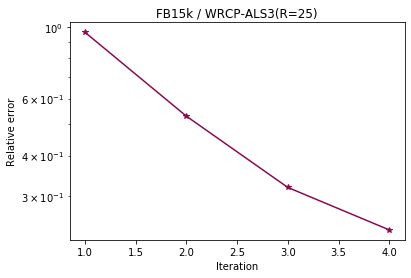

In [41]:
plt.xlabel("Iteration")
plt.ylabel("Relative error")
plt.title(f"FB15k / WRCP-ALS3(R={rank})")
#plt.xticks(np.arange(it))
plt.yscale("log")
plt.plot(np.arange(1, it+1), err_arr[:it], '-*', c="#8b0a50")

%%time
hr(valid_filter, valid_triples, a, b, c, [1, 3, 10])

In [42]:
%%time
hr(test_filter, test_triples, a, b, c, [1, 3, 10])

CPU times: user 11min 50s, sys: 15.9 ms, total: 11min 50s
Wall time: 11min 50s


(0.06876470687816356,
 0.13070711516649455,
 0.2119652621421679,
 0.11707230319900726)

## Find best parameters:

In [43]:
ranks = (25, 50, 100, 200, 300, 400)
l2 = 3e0
n_iter = 2
seed = 13

In [44]:
table_results = pd.DataFrame(
    np.zeros((len(ranks), 14)),
    index=[i for i in range(1, len(ranks) + 1)],
    columns=("iter", "rank", "l2", "time_train",
             "time_hr", "error", "hr1_valid", "hr1_test",
             "hr3_valid", "hr3_test", "hr10_valid", "hr10_test", 
             "mrr_valid", "mrr_test"),
)
table_results

,iter,rank,l2,time_train,time_hr,error,hr1_valid,hr1_test,hr3_valid,hr3_test,hr10_valid,hr10_test,mrr_valid,mrr_test
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
idx = 0
for rank in track(ranks):
    idx += 1
    # Train model
    start_tr = time.time()
    a, b, c, err_arr, it = wrcp.wrcp_als3(
        coords, values, data_shape,
        rank=rank,
        l2=l2,
        max_iter=n_iter,
        seed=seed,
        show_iter=False,
        it_over=False,
    )
    end_tr = time.time()
            
    # Find relative error
    rerr = sqrt_err_relative(
        coords, values, data_shape, a, b, c,
    )
    
    # Find Hit Rate on a validation set
    start_hr = time.time()
    hr1_valid, hr3_valid, hr10_valid, mrr_valid = hr(
        valid_filter, valid_triples, a, b, c, [1, 3, 10]
    )
    
    # Find Hit Rate on a test set
    hr1_test, hr3_test, hr10_test, mrr_test = hr(
        test_filter, test_triples, a, b, c, [1, 3, 10]
    )
    end_hr = time.time()
            
    table_results.loc[idx]["iter"] = n_iter
    table_results.loc[idx]["rank"] = rank
    table_results.loc[idx]["l2"] = l2
    table_results.loc[idx]["time_train"] = end_tr - start_tr
    table_results.loc[idx]["time_hr"] = end_hr - start_hr
    table_results.loc[idx]["error"] = rerr
    
    table_results.loc[idx]["hr1_valid"] = hr1_valid
    table_results.loc[idx]["hr1_test"] = hr1_test
    
    table_results.loc[idx]["hr3_valid"] = hr3_valid
    table_results.loc[idx]["hr3_test"] = hr3_test
    
    table_results.loc[idx]["hr10_valid"] = hr10_valid
    table_results.loc[idx]["hr10_test"] = hr10_test
    
    table_results.loc[idx]["mrr_valid"] = mrr_valid
    table_results.loc[idx]["mrr_test"] = mrr_test 

 [████████████████████████████████████████████████████████████] 6/6 [04:46:06<01:55:31, 2860.93s/it]

In [46]:
table_results

,iter,rank,l2,time_train,time_hr,error,hr1_valid,hr1_test,hr3_valid,hr3_test,hr10_valid,hr10_test,mrr_valid,mrr_test
1,2.0,25.0,3.0,107.424801,1012.864410,0.413010,0.07474,0.074216,0.11408,0.114625,0.18760,0.186267,0.113293,0.112571
2,2.0,50.0,3.0,143.025986,903.308759,0.400128,0.08374,0.082663,0.13188,0.131824,0.21560,0.213675,0.129899,0.128995
3,2.0,100.0,3.0,302.366048,1027.276570,0.384823,0.10214,0.099118,0.16572,0.163938,0.28248,0.279342,0.160986,0.158281
4,2.0,200.0,3.0,919.440675,1364.652246,0.389985,0.12876,0.127575,0.22236,0.217687,0.35406,0.350595,0.203397,0.200999
5,2.0,300.0,3.0,2396.711837,2056.467912,0.390986,0.13516,0.134567,0.24018,0.238273,0.36808,0.361988,0.214489,0.212642
6,2.0,400.0,3.0,4415.820152,2514.039263,0.391446,0.15384,0.149701,0.25598,0.253221,0.38426,0.380627,0.232010,0.228227


In [49]:
table_results.to_csv("Link_Prediction_Factors/FB15K/results.csv")

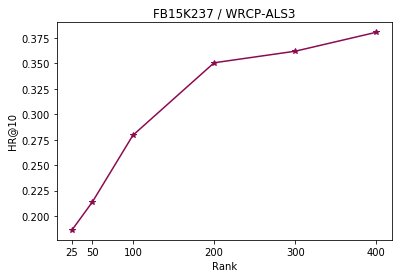

In [50]:
plt.xlabel("Rank")
plt.ylabel("HR@10")
plt.title(f"FB15k / WRCP-ALS3")
plt.xticks(table_results['rank'])
#plt.yscale("log")
plt.plot(table_results['rank'], table_results['hr10_test'], '-*', c="#8b0a50")

## Merge train and valid sets:

In [ ]:
tv_values = [1] * len(train_valid_triples)
tv_values = np.array(tv_values, dtype=np.float64)

tv_coords = np.array(train_valid_triples, dtype=np.int32)
nnz = len(train_valid_triples)
data_shape = (len(entity_list), len(relation_list), len(entity_list))
data_shape

In [ ]:
max_iter = 2
rank = 300
l2 = 3e0
seed = 13

In [ ]:
%%time
a, b, c, err_arr, it = wrcp.wrcp_als3(
    coords, values, data_shape,
    rank=rank,
    l2=l2,
    max_iter=max_iter,
    seed=seed,
    show_iter=False,
    it_over=False,
)

In [ ]:
%%time
hr(test_filter, test_triples, a, b, c, [1, 3, 10])

### Save Factors:

In [ ]:
path_factors = "Link_Prediction_Factors/FB15K/"

pickle.dump(a, open(path_factors + 'A_factor', 'wb'))
pickle.dump(b, open(path_factors + 'B_factor', 'wb'))
pickle.dump(c, open(path_factors + 'C_factor', 'wb'))
pickle.dump(err_arr, open(path_factors + 'Errors', 'wb'))

## We can load calculated factors:

In [3]:
path_factors = "Link_Prediction_Factors/FB15K/"

a = pickle.load(open(path_factors + 'A_factor', 'rb'))
b = pickle.load(open(path_factors + 'B_factor', 'rb'))
c = pickle.load(open(path_factors + 'C_factor', 'rb'))

In [ ]:
%%time
hr(valid_filter, valid_triples, a, b, c, [1, 3, 10])

In [ ]:
%%time
hr(test_filter, test_triples, a, b, c, [1, 3, 10])

## Let's look at Tucker TD:

In [4]:
import polara.lib.hosvd as hosvd

In [10]:
%%time
core_shape = (50, 50, 50)
p, q, r, g = hosvd.tucker_als(
    idx=coords,
    val=values,
    shape=data_shape,
    core_shape=core_shape,
    iters=100,
    growth_tol=0.01,
    batch_run=False,
    seed=None,
)

Step 1 of 100
growth of the core: 1.000000
Step 2 of 100
growth of the core: 0.111823
Step 3 of 100
growth of the core: 0.008425
Core is no longer growing. Norm of the core: 298.005022
Done
CPU times: user 1min 5s, sys: 1.46 s, total: 1min 7s
Wall time: 39.1 s


### Write function to calculate the error:

In [6]:
from numba import jit

In [7]:
@jit(nopython=True) 
def sqrt_err_tucker(coo_tensor, vals, shape, a, b, c, g):
    result = 0.0
    for item in range(coo_tensor.shape[0]):
        coord = coo_tensor[item]
        elem = 0.0
        for p in range(a.shape[1]):
            for q in range(b.shape[1]):
                for r in range(c.shape[1]):
                    elem += g[p, q, r] * a[coord[0], p] * b[coord[1], q] * c[coord[2], r]
        
        result += (vals[item] - elem)**2  
    return np.sqrt(result)

In [8]:
@jit(nopython=True) 
def sqrt_err_relative_tucker(coo_tensor, vals, shape, a, b, c, g):
    result = sqrt_err_tucker(coo_tensor, vals, shape, a, b, c, g)        
    return result / np.sqrt((vals**2).sum())

In [11]:
rerr = sqrt_err_relative_tucker(
    coords,
    values,
    data_shape,
    p,
    q,
    r,
    g,
)
print(f"Relative error = {rerr}")

Relative error = 0.8692521793191307
